# CLIP

CLIP (Contrastive Language–Image Pretraining) is a model developed by OpenAI that connects vision and language. It is trained on a large amount of publicly available internet text paired with images. The model learns to understand and generate meaningful representations from both images and text, making it capable of zero-shot transfer across a range of tasks.

### Environment: imports and device

In [1]:
# Imports
import torch
import clip
from PIL import Image
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# device
device = "cpu"                                  # "cuda" if torch.cuda.is_available() else "cpu"

/home/andrea/.local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model load
test ViT-L/14

In [3]:
model, preprocess = clip.load("ViT-L/14", device=device)

100%|███████████████████████████████████████| 890M/890M [01:07<00:00, 13.9MiB/s]


## CIFAR-100
The CIFAR-10 dataset is a collection of images used for machine learning and computer vision research. The dataset contains `60,000` `32x32` `color` images in `10 classes`, with 6,000 images per class. There are 50,000 training images and 10,000 test images.

The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks.

In [7]:
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
dataset = datasets.CIFAR100(
    root='../../data',
    download=True,
    transform=transform
)

labels = dataset.classes

text = clip.tokenize(labels).to(device)

dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

100%|██████████| 169001437/169001437 [00:17<00:00, 9627603.04it/s] 


Extracting ../../data/cifar-100-python.tar.gz to ../../data


## Classification

The `classify` function is used to perform zero-shot classification on the images from the CIFAR-10 dataset using the CLIP model. The function takes as input the CLIP model, the text representations of the classes, and the dataloader for the images.

The function works by iterating over the images in the dataloader and computing the image features using the CLIP model. It also computes the text features for the class labels. It then computes the similarity between the image features and text features using the dot product, which gives a measure of how similar each image is to each class label.

The softmax function is applied to these similarity scores to convert them into probabilities, and the class with the highest probability is chosen as the prediction for each image. The function returns two lists: the true labels of the images and the predicted labels.

This approach leverages the ability of the CLIP model to understand and generate meaningful representations from both images and text, enabling it to perform zero-shot classification without having been specifically trained on the CIFAR-10 classes.

In [8]:
def classify(model, text, dataloader):
    true_labels = []
    predicted_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            image_features = model.encode_image(images)
            text_features = model.encode_text(text)

            # Compute the similarity between the image and text features
            similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
            predictions = similarity.argmax(dim=-1)

            true_labels.extend(labels.cpu().numpy())
            predicted_labels.extend(predictions.cpu().numpy())

    return true_labels, predicted_labels

In [9]:
## Labels Calculation
true_labels, predicted_labels = classify(model, text, dataloader)
np.save('true_labels-cifar-100.npy', true_labels)
np.save('predicted_labels-cifar-100.npy', predicted_labels)

# true_labels = np.load('true_labels-cifar-100.npy')
# predicted_labels = np.load('predicted_labels-cifar-100.npy')

KeyboardInterrupt: 

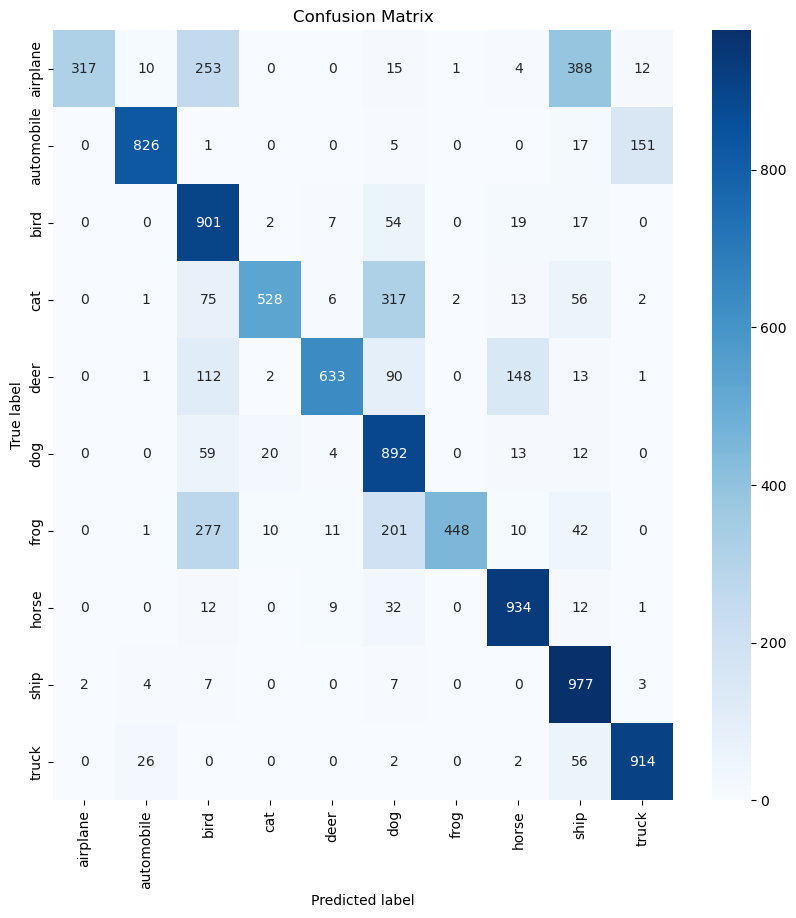

In [ ]:
confusion_mat = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 10))
sns.heatmap(confusion_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(true_labels, predicted_labels, target_names=labels))

              precision    recall  f1-score   support

    airplane       0.99      0.32      0.48      1000
  automobile       0.95      0.83      0.88      1000
        bird       0.53      0.90      0.67      1000
         cat       0.94      0.53      0.68      1000
        deer       0.94      0.63      0.76      1000
         dog       0.55      0.89      0.68      1000
        frog       0.99      0.45      0.62      1000
       horse       0.82      0.93      0.87      1000
        ship       0.61      0.98      0.75      1000
       truck       0.84      0.91      0.88      1000

    accuracy                           0.74     10000
   macro avg       0.82      0.74      0.73     10000
weighted avg       0.82      0.74      0.73     10000

